In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import cx_Oracle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('es_food_n_acc_1st_orders.dsv', sep=';', low_memory=False)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625519 entries, 0 to 625518
Data columns (total 27 columns):
SCM_N_ORDER_POS_NR              625519 non-null int64
SCM_N_ORDER_NR                  625519 non-null int64
TDT_T_KEY_ORDER_DATE            625519 non-null object
THR_C_KEY_ORDER_HOUR            625519 non-null object
SIT_N_KEY_SITE                  625519 non-null int64
CUS_N_KEY_CUSTOMER              625519 non-null int64
SCM_SALES_BMF                   625519 non-null object
SCM_SALES_CANCEL_BMF            625519 non-null object
SCM_D_FINANCE_CM1               625519 non-null object
SCM_D_FINANCE_CM2               625519 non-null object
SCM_D_ORIG_FINANCE_ORDER_NET    625519 non-null object
SCM_AP_ID                       625519 non-null int64
SCM_AS_ID                       625519 non-null int64
SCM_MASTER_AP_ID                625519 non-null int64
SCM_IS_ZSP_ORDER                625519 non-null int64
SCM_C_ORDER_STATUS              625519 non-null object
CTP_N_KEY_CUSTOME

In [4]:
data['ORDER_DATETIME'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'] + ' ' + data['THR_C_KEY_ORDER_HOUR'] + ':00', 
                                        format="%d/%m/%y %H:%M:%S")

In [5]:
data['TDT_T_KEY_ORDER_DATE'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'], format="%d/%m/%y")

In [6]:
lista = [float(str(i).replace(',','.')) for i in data['SCM_SALES_BMF'].values]
data['SCM_SALES_BMF'] = lista

In [7]:
lista0 = [float(str(i).replace(',','.')) for i in data['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
data['SCM_D_ORIG_FINANCE_ORDER_NET'] = lista0

In [8]:
lista1 = [float(str(i).replace(',','.')) for i in data['SCM_SALES_CANCEL_BMF'].values]
data['SCM_SALES_CANCEL_BMF'] = lista1

In [9]:
lista2 = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM1'].values]
data['SCM_D_FINANCE_CM1'] = lista2

In [10]:
lista3 = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM2'].values]
data['SCM_D_FINANCE_CM2'] = lista3

In [11]:
data['FINANCE_ORDER_NET'] = data['SCM_D_ORIG_FINANCE_ORDER_NET'].groupby(data['SCM_N_ORDER_NR']).transform('sum')

In [12]:
data['REL_CM1'] = data['SCM_D_FINANCE_CM1'] / data['FINANCE_ORDER_NET'] * 100

In [13]:
data['REL_CM2'] = data['SCM_D_FINANCE_CM2'] / data['FINANCE_ORDER_NET'] * 100

In [14]:
# let's convert inf and -inf into NA so that they are excluded when calculating the mean
data['REL_CM2'] = data['REL_CM2'].replace(np.inf, np.nan).replace(-np.inf, np.nan)

In [15]:
#Convert date to calendar week number and month number
data['WEEK_NUMBER'] = data['TDT_T_KEY_ORDER_DATE'].dt.week
data['MONTH_NUMBER'] = data['TDT_T_KEY_ORDER_DATE'].dt.month

Let's get PG3 & PG4 short_link names from our DB to make data more readable...

In [16]:
pg3_l = list(data['OSP_3_LEAD_P_PG_ID'].fillna(0).unique())

In [17]:
pg3_list = repr(pg3_l).replace('[','(').replace(']',')')

In [18]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_list

In [19]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
curs = conn.cursor()
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [20]:
pg3['PG_SHORTLINK_ID'] = pg3['PG_SHORTLINK'] + '_' + pg3['PG_ID'].astype(str)

In [21]:
len(set(pg3['PG_ID'])), len(set(pg3['PG_SHORTLINK_ID']))

(57, 57)

In [22]:
pg3

,PG_ID,PG_SHORTLINK,PG_SHORTLINK_ID
0,9,hundebett,hundebett_9
1,15,hundeleine_hundehalsband,hundeleine_hundehalsband_15
2,16,fressnapf,fressnapf_16
3,18,hundesnacks,hundesnacks_18
4,20,hundespielzeug,hundespielzeug_20
5,23,kratzbaum_katzenbaum,kratzbaum_katzenbaum_23
6,29,katzentoilette,katzentoilette_29
7,33,fressnapf,fressnapf_33
8,34,katzensnacks,katzensnacks_34
9,36,katzenspielzeug,katzenspielzeug_36


In [23]:
pg3_dict = {key: value for (key, value) in zip(pg3['PG_ID'], pg3['PG_SHORTLINK_ID'])}

In [24]:
pg3_dict[0] = 'null'

In [25]:
lista_pg3 = [pg3_dict[i] for i in data['OSP_3_LEAD_P_PG_ID'].fillna(0)]

In [26]:
len(lista_pg3), len(data['OSP_3_LEAD_P_PG_ID'])

(625519, 625519)

In [27]:
data['LEAD_PG3_NAME'] = lista_pg3

In [28]:
pg4_l = list(data['OSP_4_LEAD_P_PG_ID'].fillna(0).unique())

In [29]:
pg4_list = repr(pg4_l).replace('[','(').replace(']',')')

In [30]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg4_list

In [31]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
curs = conn.cursor()
pg4 = pd.read_sql(query, con = conn)
conn.close()

In [32]:
pg4_dict = {key: value for (key, value) in zip(pg4['PG_ID'], pg4['PG_SHORTLINK'])}

In [33]:
pg4_dict[-1] = 'null'

In [34]:
lista_pg4 = [pg4_dict[i] for i in data['OSP_4_LEAD_P_PG_ID'].fillna(-1)]

In [35]:
len(lista_pg4), len(data['OSP_4_LEAD_P_PG_ID'])

(625519, 625519)

In [36]:
data['LEAD_PG4_NAME'] = lista_pg4

In [37]:
data[['OSP_3_LEAD_P_PG_ID', 'LEAD_PG3_NAME', 'OSP_4_LEAD_P_PG_ID', 'LEAD_PG4_NAME']].sample(5)

,OSP_3_LEAD_P_PG_ID,LEAD_PG3_NAME,OSP_4_LEAD_P_PG_ID,LEAD_PG4_NAME
598287,252,katzenfutter_trockenfutter_252,31963,hills_prescription_diet
231429,301,katzenstreu_301,39682,sanicat
338655,251,hundefutter_trockenfutter_251,35825,taste_of_the_wild
268884,2068,katzenfutter_dose_2068,2071,felix
258016,251,hundefutter_trockenfutter_251,81396,royal_canin_veterinary_diet


In [38]:
first_orders = data[data['OSP_KO_COUNT_NET'] == 1]

In [39]:
cus_pg3_1st = {}

for i in first_orders['CUS_N_KEY_CUSTOMER'].unique():
    cus_data = first_orders[first_orders['CUS_N_KEY_CUSTOMER'] == i]
    cus_pg3_1st[i] = cus_data['LEAD_PG3_NAME'].iloc[0]

In [40]:
cus_pg3_1st

{16972262: 'kratzbaum_katzenbaum_23',
 16972273: 'katzenfutter_dose_2068',
 16972228: 'hundetransportbox_2190',
 16972245: 'katzentoilette_29',
 16969974: 'hundefutter_trockenfutter_251',
 16977727: 'ungezieferschutz_207553',
 16977749: 'katzensnacks_34',
 16973679: 'hundefutter_trockenfutter_251',
 16976790: 'hundetransportbox_2190',
 16969422: 'katzenfutter_dose_2068',
 16972840: 'hundetransportbox_2190',
 16979107: 'hundefutter_trockenfutter_251',
 16979159: 'hundebett_9',
 16979241: 'kratzbaum_katzenbaum_23',
 16974027: 'fressnapf_33',
 16975477: 'hundefutter_trockenfutter_251',
 16974625: 'katzentoilette_29',
 16971284: 'hundefutter_trockenfutter_251',
 16969869: 'hundefutter_trockenfutter_251',
 16971378: 'ungezieferschutz_207553',
 16974088: 'katzenfutter_trockenfutter_252',
 16971242: 'hundefutter_trockenfutter_251',
 16965727: 'hundefutter_trockenfutter_251',
 16971393: 'katzentoilette_29',
 16975273: 'kratzbaum_katzenbaum_23',
 16973253: 'katzenstreu_301',
 16972027: 'hundetr

In [41]:
cus_pg3_1st_list = [cus_pg3_1st[i] for i in data['CUS_N_KEY_CUSTOMER'].values]

In [42]:
len(data['CUS_N_KEY_CUSTOMER']) == len(cus_pg3_1st_list)

True

In [43]:
data['LEAD_PG3_1ST_ORD'] = cus_pg3_1st_list

In [44]:
cm2_pg3_to_pg4 = data.groupby(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER', 
                                   'OSP_3_LEAD_P_PG_ID', 'LEAD_PG3_NAME', 'OSP_4_LEAD_P_PG_ID', 'LEAD_PG4_NAME', 
                                   'LEAD_PG3_1ST_ORD'], as_index=False).agg({'SCM_D_FINANCE_CM2': 'sum',
                                                                        'OSP_KO_COUNT_NET': 'mean',
                                                                            'REL_CM2': 'sum',
                                                                            'SCM_D_ORIG_FINANCE_ORDER_NET':'sum'})

In [45]:
cm2_pg3_to_pg4.sample(10)

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,OSP_3_LEAD_P_PG_ID,LEAD_PG3_NAME,OSP_4_LEAD_P_PG_ID,LEAD_PG4_NAME,LEAD_PG3_1ST_ORD,SCM_D_FINANCE_CM2,OSP_KO_COUNT_NET,REL_CM2,SCM_D_ORIG_FINANCE_ORDER_NET
109834,101174019,2017-12-24,17845873,251,hundefutter_trockenfutter_251,283,pro_plan,hundefutter_trockenfutter_251,2.1648,4,4.412160,49.0644
42066,94085355,2017-09-09,17864698,251,hundefutter_trockenfutter_251,255,eukanuba,hundefutter_trockenfutter_251,-2.1682,1,-6.278032,34.5363
12501,90264737,2017-07-06,17247265,251,hundefutter_trockenfutter_251,682,royal_canin_size,hundefutter_trockenfutter_251,23.1227,2,9.404338,245.8727
101716,100350558,2017-12-11,18500524,251,hundefutter_trockenfutter_251,31962,hills_prescription_diet,hundefutter_trockenfutter_251,17.6574,2,24.707310,71.4663
140196,106699284,2018-03-15,18837869,2068,katzenfutter_dose_2068,260349,gourmet_perle,katzenfutter_dose_2068,-4.0241,4,-15.385821,26.1546
62863,96422264,2017-10-16,17682785,251,hundefutter_trockenfutter_251,2108,luposan,hundefutter_trockenfutter_251,12.6390,3,23.539425,53.6929
29657,92626533,2017-08-16,17627378,251,hundefutter_trockenfutter_251,2051,markus_muehle,hundefutter_trockenfutter_251,0.2526,1,0.746533,33.8364
26023,92163186,2017-08-08,17548713,29,katzentoilette_29,35032,verhalten_wohlfuehlen_katzen,katzentoilette_29,-0.3313,1,-1.986485,16.6777
130068,104442814,2018-02-11,17507909,251,hundefutter_trockenfutter_251,17798,royal_canin_breed,hundefutter_trockenfutter_251,-1.5843,5,-4.357920,36.3545
139644,106575904,2018-03-14,18239264,252,katzenfutter_trockenfutter_252,683,royal_canin,kratzbaum_katzenbaum_23,-1.5552,4,-7.133945,21.8000


In [46]:
cm2_pg3_to_pg4['LEAD_PG3_1ST_ORD'].unique()

array(['hundefutter_trockenfutter_251', 'kratzbaum_katzenbaum_23',
       'hundeleine_hundehalsband_15', 'freigehege_49828',
       'hundetransportbox_2190', 'ungezieferschutz_207553',
       'hundesnacks_18', 'hundefutter_ergaenzung_1400',
       'hundespielzeug_20', 'fressnapf_33',
       'katzenfutter_trockenfutter_252', 'sport_training_153317',
       'hundebekleidung_hundemantel_40023', 'katzentoilette_29',
       'katzenfutter_dose_2068', 'katzenstreu_301', 'hundebett_9',
       'hundefutter_nassfutter_857', 'hundepflege_409',
       'balkon_garten_2155', 'heu_streu_305',
       'hundehuette_hundetuer_2192', 'spielzeug_47', 'katzenspielzeug_36',
       'ungezieferschutz_207624', 'transport_37', 'katzensnacks_34',
       'futter_45', 'fressnapf_16', 'katzenbetten_katzenkissen_1540',
       'katzenfutter_ergaenzung_38', 'futter_ergaenzung_401',
       'spielzeug_1603', 'superbox_dog_255413'], dtype=object)

In [47]:
crosstab_ko_count_net = pd.crosstab(cm2_pg3_to_pg4['LEAD_PG3_1ST_ORD'], cm2_pg3_to_pg4['OSP_KO_COUNT_NET'], 
                                           values = cm2_pg3_to_pg4['SCM_N_ORDER_NR'],
                                          aggfunc='count').fillna(0).astype(int)

In [48]:
crosstab_ko_count_net

OSP_KO_COUNT_NET,1,2,3,4,5
LEAD_PG3_1ST_ORD,,,,,
balkon_garten_2155,993,297,169,119,85
freigehege_49828,538,155,88,49,39
fressnapf_16,361,138,77,44,34
fressnapf_33,1485,598,382,265,193
futter_45,429,218,123,74,41
futter_ergaenzung_401,52,15,6,5,3
heu_streu_305,259,123,83,55,33
hundebekleidung_hundemantel_40023,486,139,68,35,20
hundebett_9,3183,936,527,330,228


In [49]:
cm2_pg3_to_pg4[cm2_pg3_to_pg4['CUS_N_KEY_CUSTOMER'] == 18764637]

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,OSP_3_LEAD_P_PG_ID,LEAD_PG3_NAME,OSP_4_LEAD_P_PG_ID,LEAD_PG4_NAME,LEAD_PG3_1ST_ORD,SCM_D_FINANCE_CM2,OSP_KO_COUNT_NET,REL_CM2,SCM_D_ORIG_FINANCE_ORDER_NET


In [50]:
next_orders = cm2_pg3_to_pg4[cm2_pg3_to_pg4['OSP_KO_COUNT_NET'] != 1]

In [51]:
crosstab_pg3_to_pg4_orders = pd.crosstab(next_orders['LEAD_PG3_1ST_ORD'], next_orders['LEAD_PG4_NAME'], 
                                           values = next_orders['SCM_N_ORDER_NR'],
                                          aggfunc='count').fillna(0).astype(int).apply(lambda x: x/x.sum() * 100, axis=1).round(2)

In [52]:
crosstab_pg3_to_pg4_orders

LEAD_PG4_NAME,acana,advance,advance_breed,affinity_advance,affinity_advance_veterinary_diets,affinity_ultima,agility,alle_zubehoerartikel,almo_nature,almo_nature_holistic,...,zahnpflege,zahnpflege_snacks,zimmerkaefig,zoolove,zoolove_snacks,zooplus,zooplus_bio,zooplus_classic,zooplus_geschenkgutschein,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,1.19,0.00,0.00,2.99,0.15,2.69,0.00,0.00,0.45,0.00,...,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
freigehege_49828,1.81,0.00,0.00,0.91,0.00,0.30,0.00,0.00,0.00,0.00,...,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.14
fressnapf_16,3.41,0.00,0.00,3.75,0.68,0.00,0.00,0.00,0.00,0.34,...,0.00,0.34,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00
fressnapf_33,1.04,0.42,0.00,1.81,0.56,1.46,0.00,0.00,0.63,0.07,...,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.21
futter_45,0.66,0.00,0.00,0.88,0.22,0.44,0.00,0.00,0.00,0.00,...,0.00,0.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,43.86
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31.03
heu_streu_305,1.02,0.00,0.00,2.38,0.34,0.00,0.00,0.00,0.00,0.00,...,0.00,1.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.29
hundebekleidung_hundemantel_40023,3.44,0.00,0.00,3.05,1.15,0.76,0.00,0.00,0.00,0.00,...,0.38,2.67,0.00,0.00,0.00,0.00,0.00,0.38,0.00,0.00
hundebett_9,4.11,0.15,0.05,2.52,1.19,0.49,0.05,0.00,0.00,0.00,...,0.10,1.68,0.00,0.00,0.00,0.00,0.05,0.05,0.00,0.20


In [53]:
crosstab_pg3_to_pg4_orders.columns.ravel()

array(['acana', 'advance', 'advance_breed', 'affinity_advance',
       'affinity_advance_veterinary_diets', 'affinity_ultima', 'agility',
       'alle_zubehoerartikel', 'almo_nature', 'almo_nature_holistic',
       'almo_nature_labels', 'alpha_spirit', 'animonda',
       'animonda_rafine', 'animonda_rafinee', 'antizug_maulkorb',
       'applaws', 'applaws_katzenfutter', 'applaws_natures_calling',
       'aquarien_komplett', 'aquarienkies', 'aquarium_aussenfilter',
       'aquarium_filter', 'aquarium_unterschrank', 'aquarium_zubehoer',
       'arden_grange', 'arden_grange_katzenfutter',
       'arden_grange_partners', 'aufbau_leistung_zucht',
       'augen_ohrenpflege', 'augenpflege',
       'aussergewoehnliche_katzenbetten', 'autoschondecken',
       'autoschutzgitter', 'bade_sand', 'badehaeuser', 'baelle',
       'baldrian_katzenspielzeug', 'beaphar_spezialdiaet', 'belcando',
       'benek', 'beschaeftigung', 'betten', 'biokats', 'biskuits_kekse',
       'bodengrund', 'bosch', 'bozita

In [54]:
pg4_selection = [i for i in crosstab_pg3_to_pg4_orders.columns if (crosstab_pg3_to_pg4_orders[i] > 5).any()]

In [55]:
len(pg4_selection)

47

In [56]:
np.array(pg4_selection)

array(['affinity_advance', 'antizug_maulkorb', 'autoschondecken',
       'bruecken_treppen', 'cats_best', 'cellulose_einstreu', 'felix',
       'gelenke_knochen', 'geschirre', 'gesundheits_betten', 'gourmet',
       'halsband', 'hanfstreu', 'heu', 'heuraufen',
       'hills_prescription_diet', 'hundemantel', 'hundetransportbox',
       'kanarie', 'katze_ergaenzung_gelenke', 'katzennetz',
       'katzentraenke', 'knuspersnacks', 'maisstreu', 'meerschweinchen',
       'metall', 'natural_greatness', 'papagei', 'pasten_cremes',
       'purizon', 'royal_canin', 'royal_canin_breed',
       'royal_canin_katzenfutter', 'royal_canin_size',
       'royal_canin_veterinary_diet', 'sanicat', 'schlafhaeuschen',
       'selection', 'spitzdach_hundehuette', 'spoton',
       'taste_of_the_wild', 'tigerino', 'toilette', 'transportkaefige',
       'verhalten_wohlfuehlen_katzen', 'zahnpflege_snacks',
       'zwergkaninchen'], dtype='<U28')

In [57]:
crosstab_pg3_to_pg4_orders[pg4_selection]

LEAD_PG4_NAME,affinity_advance,antizug_maulkorb,autoschondecken,bruecken_treppen,cats_best,cellulose_einstreu,felix,gelenke_knochen,geschirre,gesundheits_betten,...,selection,spitzdach_hundehuette,spoton,taste_of_the_wild,tigerino,toilette,transportkaefige,verhalten_wohlfuehlen_katzen,zahnpflege_snacks,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,2.99,0.30,0.15,0.00,1.04,0.00,0.75,0.00,0.15,0.00,...,0.00,0.15,1.19,1.19,2.54,0.00,0.00,1.34,0.30,0.00
freigehege_49828,0.91,0.91,0.00,0.00,2.11,1.51,0.00,0.00,1.81,0.60,...,0.30,0.60,2.42,3.32,0.30,7.25,1.51,0.00,0.30,5.14
fressnapf_16,3.75,0.68,0.68,0.00,0.00,0.00,1.02,0.34,3.75,2.39,...,0.00,1.02,2.73,4.10,0.00,2.05,0.68,1.02,0.34,0.00
fressnapf_33,1.81,0.00,0.00,0.00,1.32,0.00,1.46,0.00,0.14,0.07,...,0.00,0.07,0.83,1.46,5.63,0.49,0.35,1.67,0.21,0.21
futter_45,0.88,0.00,0.00,0.00,1.10,3.73,0.00,0.00,0.44,0.22,...,0.00,0.00,0.88,1.32,1.10,0.88,0.22,0.00,0.22,43.86
futter_ergaenzung_401,0.00,0.00,0.00,0.00,3.45,3.45,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31.03
heu_streu_305,2.38,0.34,0.00,0.34,0.68,21.43,0.00,0.00,0.00,0.00,...,0.34,0.00,0.34,0.34,1.02,0.00,0.00,0.00,1.36,14.29
hundebekleidung_hundemantel_40023,3.05,2.67,1.15,0.00,0.00,0.00,0.76,0.76,2.67,1.53,...,0.00,0.00,0.76,5.73,0.38,1.15,0.38,0.00,2.67,0.00
hundebett_9,2.52,0.40,0.45,0.00,0.45,0.05,0.49,1.14,2.82,6.23,...,0.05,0.20,1.73,2.87,0.59,0.89,0.94,0.20,1.68,0.20


In [58]:
crosstab_pg3_to_pg4_orders[pg4_selection].to_csv('es_rel_orders_lead_pg3_and_pg4_selection.csv', sep=';', index=True, encoding='utf-8')

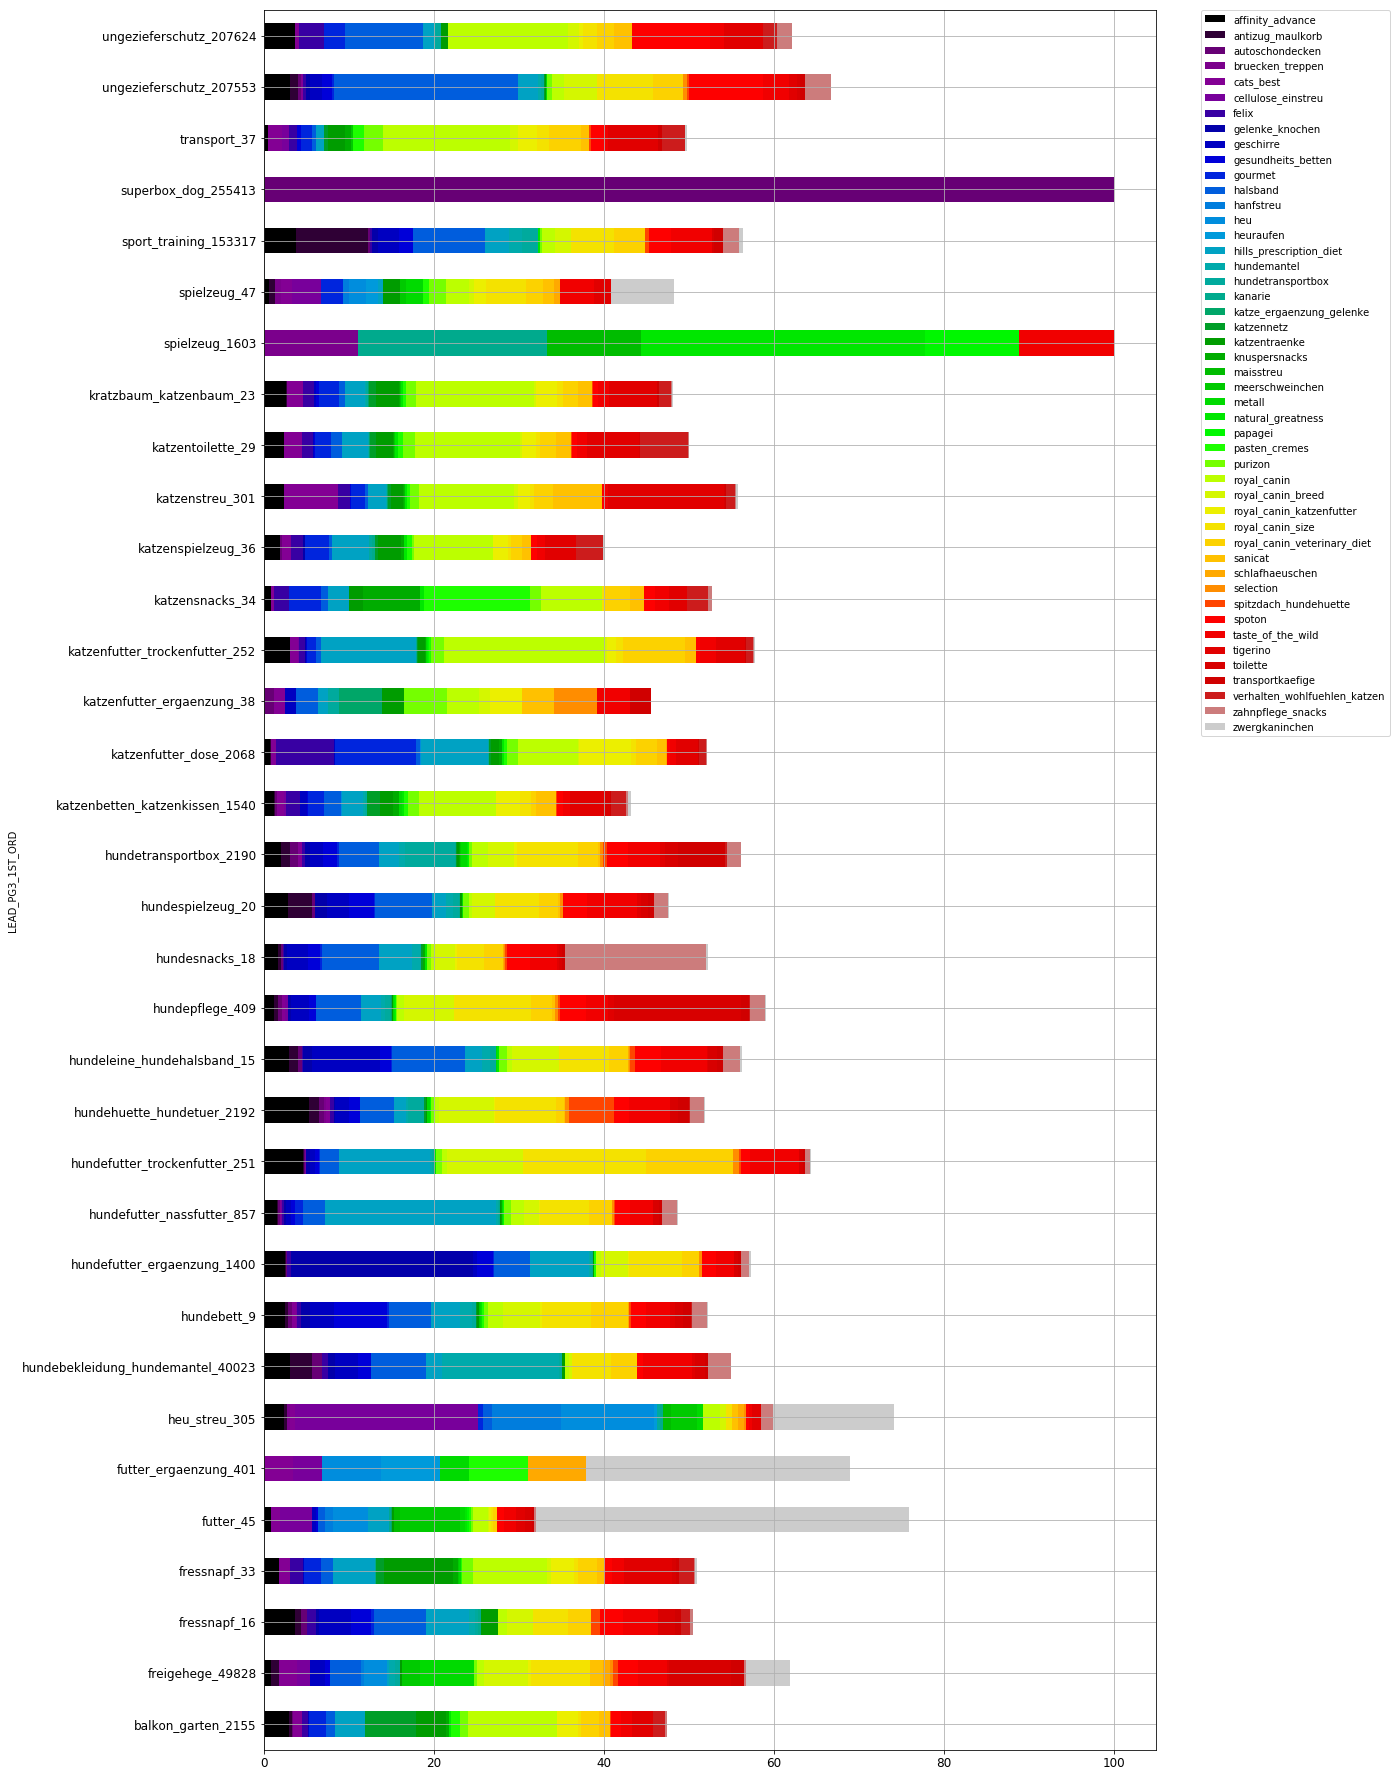

In [59]:
crosstab_pg3_to_pg4_orders[pg4_selection].plot(kind='barh', stacked=True, figsize=(16, 32), grid=True, fontsize=12, colormap='nipy_spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.tight_layout()
#plt.savefig('rel_orders_accesories_and_pg4_sel')

In [60]:
crosstab_pg3_to_pg4_cm2 = pd.crosstab(cm2_pg3_to_pg4['LEAD_PG3_1ST_ORD'], cm2_pg3_to_pg4['OSP_KO_COUNT_NET'], 
                                           values = cm2_pg3_to_pg4['SCM_D_FINANCE_CM2'],
                                          aggfunc='sum').fillna(0).round(2)

In [61]:
crosstab_pg3_to_pg4_cm2

OSP_KO_COUNT_NET,1,2,3,4,5
LEAD_PG3_1ST_ORD,,,,,
balkon_garten_2155,7474.58,1469.06,902.00,685.69,439.96
freigehege_49828,4137.23,890.18,580.91,365.86,278.38
fressnapf_16,1589.60,633.30,435.15,307.40,200.83
fressnapf_33,7769.62,2824.84,2052.54,1395.48,1229.23
futter_45,2776.77,1541.00,1071.03,522.07,293.39
futter_ergaenzung_401,285.88,56.39,26.74,25.48,17.61
heu_streu_305,1897.87,951.76,653.95,425.63,259.49
hundebekleidung_hundemantel_40023,3664.07,747.69,374.40,276.94,127.72
hundebett_9,19984.23,5124.87,3363.09,2204.92,1472.18


In [62]:
crosstab_pg3_to_pg4_perc_cm2 = pd.crosstab(next_orders['LEAD_PG3_1ST_ORD'], next_orders['LEAD_PG4_NAME'], 
                                           values = next_orders['SCM_D_FINANCE_CM2'],
                                          aggfunc='sum').fillna(0).astype(int).apply(lambda x: x/x.sum() * 100, axis=1).round(2)

In [63]:
crosstab_pg3_to_pg4_perc_cm2

LEAD_PG4_NAME,acana,advance,advance_breed,affinity_advance,affinity_advance_veterinary_diets,affinity_ultima,agility,alle_zubehoerartikel,almo_nature,almo_nature_holistic,...,zahnpflege,zahnpflege_snacks,zimmerkaefig,zoolove,zoolove_snacks,zooplus,zooplus_bio,zooplus_classic,zooplus_geschenkgutschein,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,2.26,0.00,0.00,1.33,0.00,-0.17,0.00,0.00,0.75,0.00,...,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
freigehege_49828,2.56,0.00,0.00,0.53,0.00,0.05,0.00,0.00,0.00,0.00,...,0.00,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.82
fressnapf_16,5.99,0.00,0.00,1.63,0.26,0.00,0.00,0.00,0.00,0.26,...,0.00,-0.39,1.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00
fressnapf_33,2.88,0.28,0.00,0.70,0.11,0.63,0.00,0.00,0.34,0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.27
futter_45,0.76,0.00,0.00,0.47,0.38,0.35,0.00,0.00,0.00,0.00,...,0.00,-0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,40.76
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,41.32
heu_streu_305,1.15,0.00,0.00,1.64,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.38
hundebekleidung_hundemantel_40023,5.03,0.00,0.00,0.47,0.80,-0.40,0.00,0.00,0.00,0.00,...,0.34,1.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
hundebett_9,7.34,0.18,0.02,1.47,0.26,0.78,0.31,0.00,0.00,0.00,...,0.03,0.84,0.00,0.00,0.00,0.00,0.02,0.05,0.00,0.27


In [64]:
crosstab_pg3_to_pg4_perc_cm2.columns.ravel()

array(['acana', 'advance', 'advance_breed', 'affinity_advance',
       'affinity_advance_veterinary_diets', 'affinity_ultima', 'agility',
       'alle_zubehoerartikel', 'almo_nature', 'almo_nature_holistic',
       'almo_nature_labels', 'alpha_spirit', 'animonda',
       'animonda_rafine', 'animonda_rafinee', 'antizug_maulkorb',
       'applaws', 'applaws_katzenfutter', 'applaws_natures_calling',
       'aquarien_komplett', 'aquarienkies', 'aquarium_aussenfilter',
       'aquarium_filter', 'aquarium_unterschrank', 'aquarium_zubehoer',
       'arden_grange', 'arden_grange_katzenfutter',
       'arden_grange_partners', 'aufbau_leistung_zucht',
       'augen_ohrenpflege', 'augenpflege',
       'aussergewoehnliche_katzenbetten', 'autoschondecken',
       'autoschutzgitter', 'bade_sand', 'badehaeuser', 'baelle',
       'baldrian_katzenspielzeug', 'beaphar_spezialdiaet', 'belcando',
       'benek', 'beschaeftigung', 'betten', 'biokats', 'biskuits_kekse',
       'bodengrund', 'bosch', 'bozita

In [65]:
pg4_cm2_selection = [i for i in crosstab_pg3_to_pg4_perc_cm2.columns if (crosstab_pg3_to_pg4_perc_cm2[i] > 5).any()]

In [66]:
len(pg4_cm2_selection)

58

In [67]:
crosstab_pg3_to_pg4_perc_cm2[pg4_cm2_selection]

LEAD_PG4_NAME,acana,affinity_advance_veterinary_diets,antizug_maulkorb,applaws,autoschondecken,bosch,bruecken_treppen,cats_best,cellulose_einstreu,concept_for_life_cat,...,spitzdach_hundehuette,staubsauger,taste_of_the_wild,tigerino,toilette,transportkaefige,tunnel_hoehlen,ungezieferschutz,zahnpflege_snacks,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,2.26,0.00,0.26,0.75,0.26,0.00,0.00,0.41,0.00,0.29,...,0.46,0.00,0.75,3.48,0.00,0.00,0.00,0.00,0.23,0.00
freigehege_49828,2.56,0.00,0.73,-0.05,0.00,0.00,0.00,1.69,1.79,0.00,...,0.48,0.00,4.45,0.48,5.90,1.11,0.19,0.00,0.24,6.82
fressnapf_16,5.99,0.26,0.72,0.00,0.91,0.00,0.00,0.00,0.00,0.00,...,2.86,0.00,7.35,0.00,2.08,0.78,0.20,0.00,-0.39,0.00
fressnapf_33,2.88,0.11,0.00,0.19,0.00,0.00,0.00,1.48,0.00,0.93,...,0.01,0.00,2.23,5.15,0.36,0.77,0.00,0.00,0.00,0.27
futter_45,0.76,0.38,0.00,0.15,0.00,0.00,0.00,1.03,3.21,0.00,...,0.00,0.00,1.91,0.65,1.00,0.29,0.18,0.00,-0.06,40.76
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.96,2.48,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,7.44,5.79,0.00,41.32
heu_streu_305,1.15,0.00,0.09,0.44,0.00,0.00,0.27,0.98,24.02,0.00,...,0.00,0.00,1.20,1.11,0.00,0.00,0.00,0.00,0.31,17.38
hundebekleidung_hundemantel_40023,5.03,0.80,2.01,1.61,0.60,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,12.06,1.41,1.14,0.74,0.00,0.00,1.41,0.00
hundebett_9,7.34,0.26,0.28,0.00,0.89,0.10,0.00,0.38,0.05,0.25,...,0.46,0.17,6.20,0.54,0.79,1.02,0.00,0.11,0.84,0.27


In [68]:
crosstab_pg3_to_pg4_perc_cm2[pg4_cm2_selection].to_csv('es_rel_cm2_lead_pg3_and_pg4_selection.csv', sep=';',
                                                      index=True, encoding='utf-8')

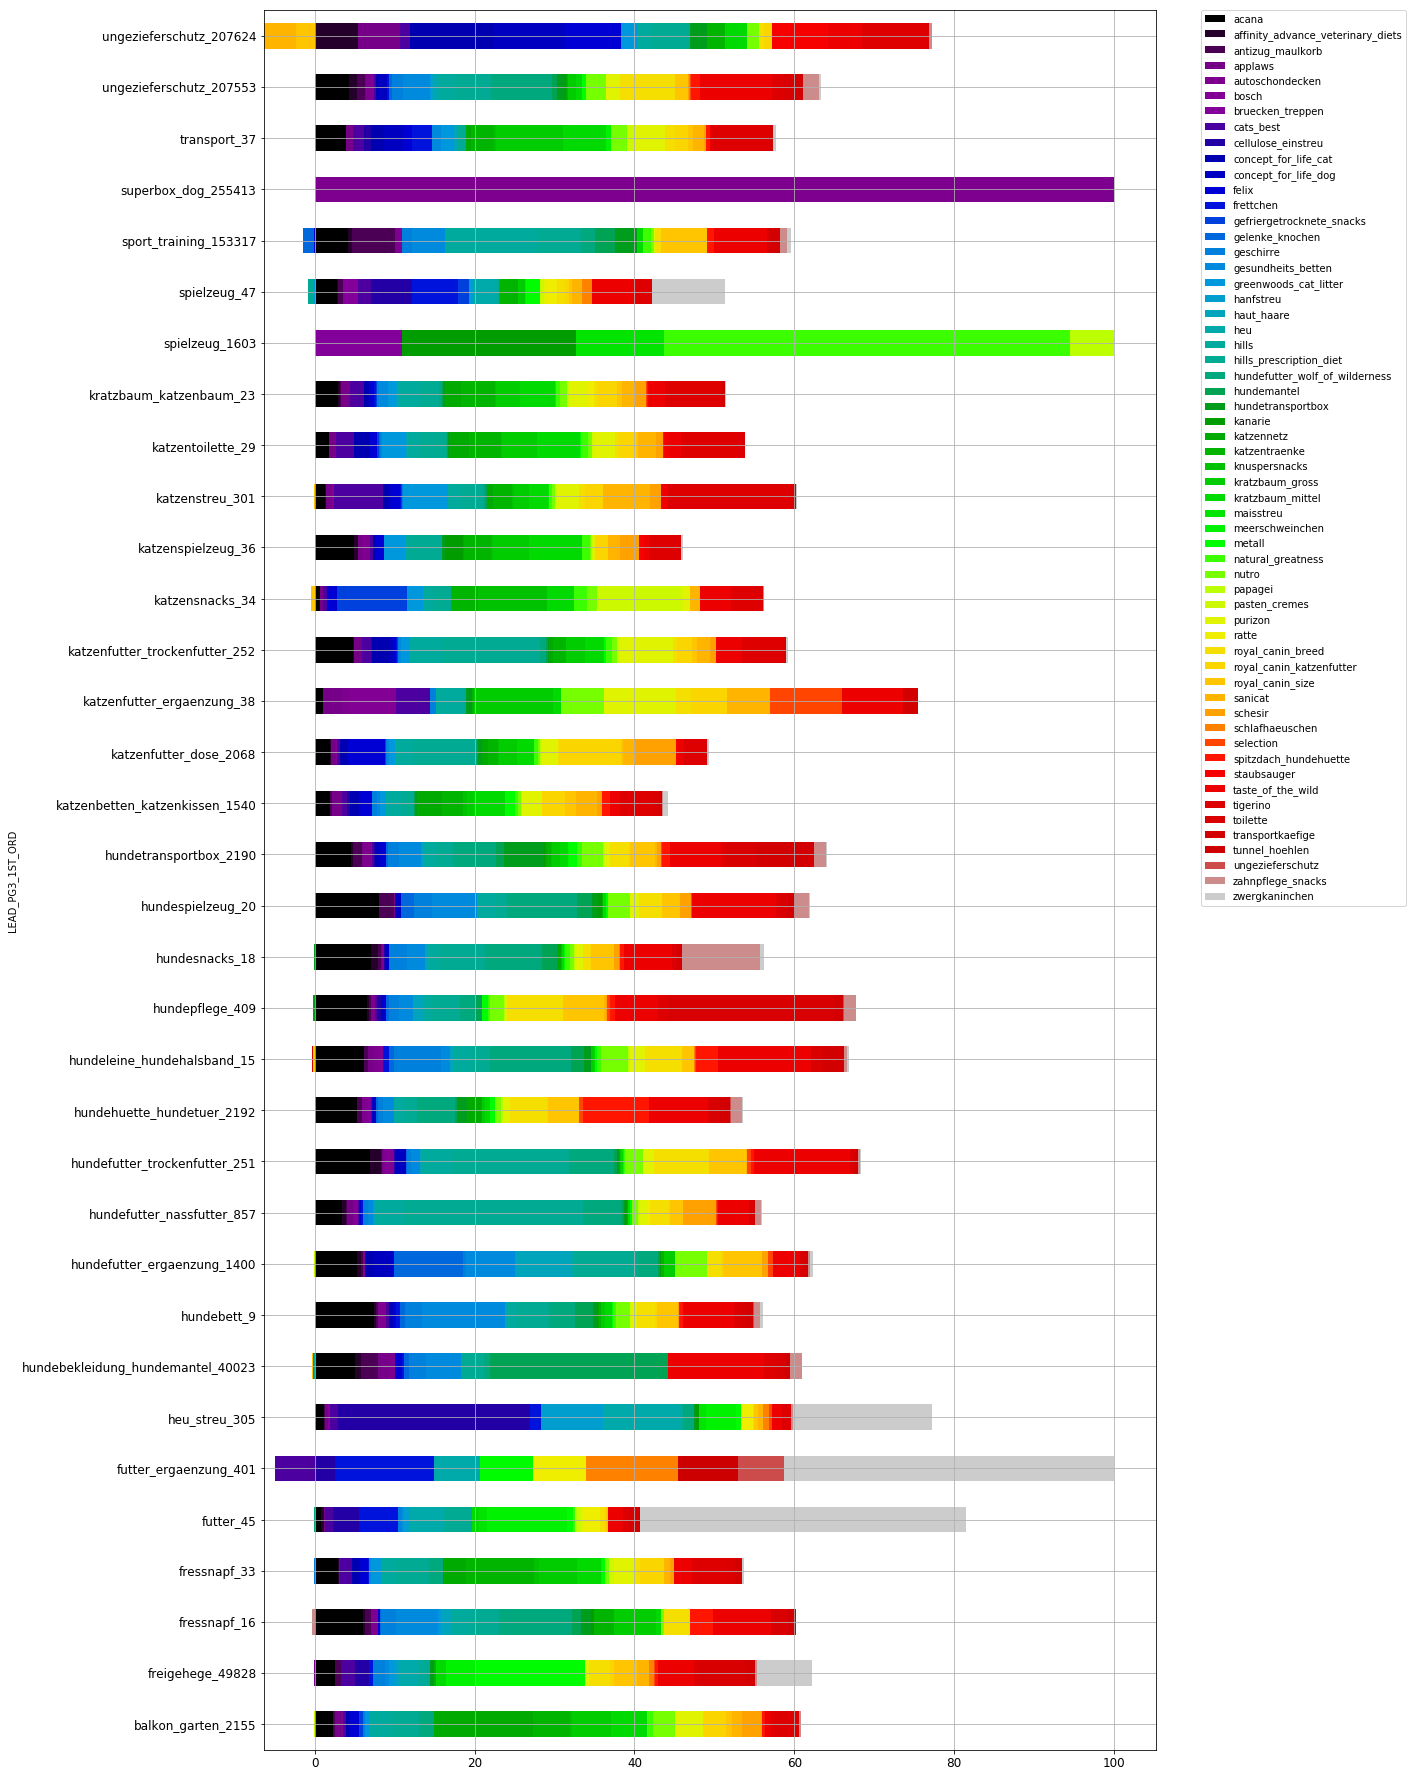

In [69]:
crosstab_pg3_to_pg4_perc_cm2[crosstab_pg3_to_pg4_perc_cm2.index != 'geschenkgutscheine_17947'][pg4_cm2_selection]\
.plot(kind='barh', stacked=True, figsize=(16, 32), grid=True, fontsize=12, colormap='nipy_spectral')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [70]:
cm2_pg3_to_pg4.sample(10)

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,OSP_3_LEAD_P_PG_ID,LEAD_PG3_NAME,OSP_4_LEAD_P_PG_ID,LEAD_PG4_NAME,LEAD_PG3_1ST_ORD,SCM_D_FINANCE_CM2,OSP_KO_COUNT_NET,REL_CM2,SCM_D_ORIG_FINANCE_ORDER_NET
83236,98439935,2017-11-15,17976226,251,hundefutter_trockenfutter_251,180361,hundefutter_wolf_of_wilderness,hundefutter_trockenfutter_251,6.4478,2,17.140108,37.6182
41258,93993637,2017-09-07,17849264,2068,katzenfutter_dose_2068,11751,applaws_katzenfutter,katzenfutter_dose_2068,9.1173,1,15.332418,59.4642
94538,99536073,2017-11-30,18277222,18,hundesnacks_18,2193,drops_leckerli,hundesnacks_18,-2.8834,1,-8.604852,33.5090
90572,99158740,2017-11-25,18642566,9,hundebett_9,97768,betten,hundebett_9,4.6218,1,20.332049,22.7316
123171,103104002,2018-01-23,18645559,2068,katzenfutter_dose_2068,218624,royal_canin_veterinary_diet_feline_nassfutter,katzenfutter_dose_2068,1.8830,3,5.055644,37.2455
79189,98030406,2017-11-09,18227047,251,hundefutter_trockenfutter_251,17798,royal_canin_breed,hundefutter_trockenfutter_251,2.1858,2,5.465743,39.9909
45819,94509447,2017-09-16,17931675,207553,ungezieferschutz_207553,207615,halsband,ungezieferschutz_207553,-3.7909,1,-13.721175,27.6281
138834,106395246,2018-03-11,18370309,2068,katzenfutter_dose_2068,2072,gourmet,katzenstreu_301,-0.0997,5,-0.283236,35.2003
17266,90945455,2017-07-18,17281147,23,kratzbaum_katzenbaum_23,2060,kratzbaum_mittel,kratzbaum_katzenbaum_23,4.1272,2,9.736603,42.3885
102669,100452649,2017-12-12,18823465,301,katzenstreu_301,3243,golden_grey,katzenstreu_301,1.3494,1,6.383039,21.1404


In [71]:
cm2_pg3_to_pg4['REL_CM2'].describe()

count    1.612010e+05
mean    -7.253418e+12
std      2.912236e+15
min     -1.169258e+18
25%     -5.054671e-01
50%      7.388474e+00
75%      1.506331e+01
max      8.643778e+01
Name: REL_CM2, dtype: float64

As we have some orders with net_sales = 0, CM2% becames extremely high or low and can lead us into trouble when calculating the CM2% on average per Lead PG4

In [72]:
cm2_pg3_to_pg4_subset = cm2_pg3_to_pg4[cm2_pg3_to_pg4['SCM_D_ORIG_FINANCE_ORDER_NET'] >= 1]

In [73]:
next_orders_subset = cm2_pg3_to_pg4_subset[cm2_pg3_to_pg4_subset['OSP_KO_COUNT_NET'] != 1]

In [74]:
pg3_orders_count_net_cm2 = pd.crosstab(cm2_pg3_to_pg4_subset['LEAD_PG3_1ST_ORD'], cm2_pg3_to_pg4_subset['OSP_KO_COUNT_NET'], 
                                           values = cm2_pg3_to_pg4_subset['REL_CM2'],
                                          aggfunc='mean').fillna(0).round(2)

In [75]:
pg3_orders_count_net_cm2

OSP_KO_COUNT_NET,1,2,3,4,5
LEAD_PG3_1ST_ORD,,,,,
balkon_garten_2155,18.93,10.74,10.68,11.51,10.63
freigehege_49828,19.06,14.01,13.96,14.25,14.55
fressnapf_16,13.38,8.36,11.20,10.99,9.95
fressnapf_33,10.84,9.51,10.21,9.37,12.04
futter_45,16.98,16.85,19.34,16.88,15.55
futter_ergaenzung_401,17.10,8.91,10.26,13.42,11.68
heu_streu_305,19.35,18.41,18.58,18.14,18.46
hundebekleidung_hundemantel_40023,25.00,14.64,13.32,12.11,11.54
hundebett_9,13.23,10.06,10.87,10.76,11.34


In [76]:
crosstab_pg3_to_pg4_rel_cm2 = pd.crosstab(next_orders_subset['LEAD_PG3_1ST_ORD'], next_orders_subset['LEAD_PG4_NAME'], 
                                           values = next_orders_subset['REL_CM2'],
                                          aggfunc='mean').fillna(0).round(2)

In [77]:
crosstab_pg3_to_pg4_rel_cm2

LEAD_PG4_NAME,acana,advance,advance_breed,affinity_advance,affinity_advance_veterinary_diets,affinity_ultima,agility,alle_zubehoerartikel,almo_nature,almo_nature_holistic,...,zahnpflege,zahnpflege_snacks,zimmerkaefig,zoolove,zoolove_snacks,zooplus,zooplus_bio,zooplus_classic,zooplus_geschenkgutschein,zwergkaninchen
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,16.82,0.00,0.00,4.09,-3.41,-0.61,0.00,0.00,14.74,0.00,...,0.00,11.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
freigehege_49828,17.21,0.00,0.00,6.20,0.00,4.79,0.00,0.00,0.00,0.00,...,0.00,12.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.67
fressnapf_16,12.26,0.00,0.00,3.71,5.38,0.00,0.00,0.00,0.00,12.01,...,0.00,-17.76,18.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
fressnapf_33,19.16,9.25,0.00,2.59,1.44,2.96,0.00,0.00,4.29,13.06,...,0.00,-5.15,0.00,0.00,0.00,0.00,0.00,15.39,0.00,19.41
futter_45,14.70,0.00,0.00,8.06,15.64,6.12,0.00,0.00,0.00,0.00,...,0.00,-4.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.51
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.15
heu_streu_305,15.74,0.00,0.00,8.92,-0.11,0.00,0.00,0.00,0.00,0.00,...,0.00,3.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.65
hundebekleidung_hundemantel_40023,15.03,0.00,0.00,-0.24,0.41,-5.30,0.00,0.00,0.00,0.00,...,16.32,5.36,0.00,0.00,0.00,0.00,0.00,1.17,0.00,0.00
hundebett_9,15.68,6.20,13.08,3.66,1.57,11.13,35.26,0.00,0.00,0.00,...,10.24,6.03,0.00,0.00,0.00,0.00,15.40,20.25,0.00,21.68


In [78]:
crosstab_pg3_to_pg4_rel_cm2.columns.ravel()

array(['acana', 'advance', 'advance_breed', 'affinity_advance',
       'affinity_advance_veterinary_diets', 'affinity_ultima', 'agility',
       'alle_zubehoerartikel', 'almo_nature', 'almo_nature_holistic',
       'almo_nature_labels', 'alpha_spirit', 'animonda',
       'animonda_rafine', 'animonda_rafinee', 'antizug_maulkorb',
       'applaws', 'applaws_katzenfutter', 'applaws_natures_calling',
       'aquarien_komplett', 'aquarienkies', 'aquarium_aussenfilter',
       'aquarium_filter', 'aquarium_unterschrank', 'aquarium_zubehoer',
       'arden_grange', 'arden_grange_katzenfutter',
       'arden_grange_partners', 'aufbau_leistung_zucht',
       'augen_ohrenpflege', 'augenpflege',
       'aussergewoehnliche_katzenbetten', 'autoschondecken',
       'autoschutzgitter', 'bade_sand', 'badehaeuser', 'baelle',
       'baldrian_katzenspielzeug', 'beaphar_spezialdiaet', 'belcando',
       'benek', 'beschaeftigung', 'betten', 'biokats', 'biskuits_kekse',
       'bodengrund', 'bosch', 'bozita

In [79]:
pg4_rel_cm2_selection = [i for i in crosstab_pg3_to_pg4_rel_cm2.columns if (crosstab_pg3_to_pg4_rel_cm2[i] < 0).any()]

In [80]:
len(pg4_rel_cm2_selection)

153

In [81]:
np.array(pg4_rel_cm2_selection)

array(['advance', 'advance_breed', 'affinity_advance',
       'affinity_advance_veterinary_diets', 'affinity_ultima',
       'almo_nature_holistic', 'alpha_spirit', 'animonda',
       'animonda_rafine', 'applaws', 'applaws_katzenfutter',
       'aquarien_komplett', 'aquarium_zubehoer', 'augen_ohrenpflege',
       'autoschutzgitter', 'baelle', 'brekkies', 'brekkies_katzenfutter',
       'buersten', 'cat_and_clean', 'cat_chow', 'catessy', 'cats_best',
       'concept_for_life_dog', 'diverse_marken_katzenstreu',
       'dogmio_trockenfutter', 'drops_leckerli', 'earthborn', 'edelstahl',
       'einbautueren', 'erziehungshilfen', 'exklusive_katzentoilette',
       'extreme_classic', 'felix', 'flachdach_hundehuette',
       'flexi_classic_special', 'flexi_vario', 'frisbee',
       'funktionsleine', 'furminator', 'futterbeutel_dummy',
       'gefriergetrocknet', 'gefriergetrocknete_snacks',
       'gelenke_knochen', 'geschirre', 'golden_grey', 'gourmet',
       'gourmet_perle', 'greenies', 'g

In [82]:
pd.options.display.float_format = '{:.2f}'.format
crosstab_pg3_to_pg4_rel_cm2[pg4_rel_cm2_selection]

LEAD_PG4_NAME,advance,advance_breed,affinity_advance,affinity_advance_veterinary_diets,affinity_ultima,almo_nature_holistic,alpha_spirit,animonda,animonda_rafine,applaws,...,vom_pferd,vom_schwein,wasserpflege,weidenhoehlen,whiskas,whiskas_katzenfutter,zahngesundheit,zahnpflege,zahnpflege_snacks,zooplus_bio
LEAD_PG3_1ST_ORD,,,,,,,,,,,,,,,,,,,,,
balkon_garten_2155,0.00,0.00,4.09,-3.41,-0.61,0.00,18.05,0.00,0.00,7.55,...,0.00,0.00,0.00,15.08,6.76,19.36,0.00,0.00,11.11,0.00
freigehege_49828,0.00,0.00,6.20,0.00,4.79,0.00,0.00,0.00,0.00,-5.10,...,0.00,0.00,0.00,0.00,0.00,2.85,0.00,0.00,12.26,0.00
fressnapf_16,0.00,0.00,3.71,5.38,0.00,12.01,-3.64,0.00,0.00,0.00,...,0.00,0.00,0.00,-0.11,0.00,0.00,0.00,0.00,-17.76,0.00
fressnapf_33,9.25,0.00,2.59,1.44,2.96,13.06,21.92,14.82,9.53,3.02,...,0.00,0.00,0.00,22.18,0.00,11.49,0.00,0.00,-5.15,0.00
futter_45,0.00,0.00,8.06,15.64,6.12,0.00,0.00,0.00,0.00,6.30,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-4.68,0.00
futter_ergaenzung_401,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
heu_streu_305,0.00,0.00,8.92,-0.11,0.00,0.00,0.00,0.00,0.00,10.28,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.36,0.00
hundebekleidung_hundemantel_40023,0.00,0.00,-0.24,0.41,-5.30,0.00,20.03,0.00,0.00,22.35,...,0.00,0.00,2.40,0.00,0.00,0.00,0.00,16.32,5.36,0.00
hundebett_9,6.20,13.08,3.66,1.57,11.13,0.00,23.11,13.14,17.16,7.03,...,2.30,8.76,0.00,0.00,0.00,-1.95,3.65,10.24,6.03,15.40


In [83]:
crosstab_pg3_to_pg4_rel_cm2[pg4_rel_cm2_selection].to_csv('es_relative_cm2_lead_pg3_and_pg4_selection.csv',
                                                          sep=';', index=True, encoding='utf-8')

In [84]:
pd.crosstab(next_orders_subset['LEAD_PG3_1ST_ORD'], next_orders_subset['LEAD_PG4_NAME'], 
                                           values = next_orders_subset['REL_CM2'],
                                          aggfunc=[len, np.mean]).fillna(0).round(2).reorder_levels([1, 0], axis=1).sort_index(axis=1)

LEAD_PG4_NAME                       acana       advance       advance_breed  \
                                      len  mean     len  mean           len   
LEAD_PG3_1ST_ORD                                                              
balkon_garten_2155                   8.00 16.82    0.00  0.00          0.00   
freigehege_49828                     6.00 17.21    0.00  0.00          0.00   
fressnapf_16                        10.00 12.26    0.00  0.00          0.00   
fressnapf_33                        15.00 19.16    6.00  9.25          0.00   
futter_45                            3.00 14.70    0.00  0.00          0.00   
futter_ergaenzung_401                0.00  0.00    0.00  0.00          0.00   
heu_streu_305                        3.00 15.74    0.00  0.00          0.00   
hundebekleidung_hundemantel_40023    9.00 15.03    0.00  0.00          0.00   
hundebett_9                         83.00 15.68    3.00  6.20          1.00   
hundefutter_ergaenzung_1400         14.00 15.36    4.00 11.94          2.00   
hundefutter_nassfutter_857          38.00 15.22    1.00  6.32          0.00   
hundefutter_trockenfutter_251     1080.00 14.83   11.00  9.78         50.00   
hundehuette_hundetuer_2192          30.00 14.83    0.00  0.00          0.00   
hundeleine_hundehalsband_15         29.00 15.52    2.00  1.32          1.00   
hundepflege_409                     38.00 15.19    3.00 17.04          2.00   
hundesnacks_18                      33.00 17.04    0.00  0.00          3.00   
hundespielzeug_20                   27.00 15.77    0.00  0.00          1.00   
hundetransportbox_2190              56.00 14.78    5.00 12.34          0.00   
katzenbetten_katzenkissen_1540      10.00 15.71    0.00  0.00          0.00   
katzenfutter_dose_2068              46.00 14.41    6.00  4.69          0.00   
katzenfutter_ergaenzung_38           1.00 11.12    0.00  0.00          0.00   
katzenfutter_trockenfutter_252     281.00 14.65    6.00 -1.10          0.00   
katzensnacks_34                      1.00 21.10    0.00  0.00          0.00   
katzenspielzeug_36                  12.00 14.81    0.00  0.00          0.00   
katzenstreu_301                     21.00 13.91    7.00 -1.15          0.00   
katzentoilette_29                   27.00 14.28    2.00  7.13          0.00   
kratzbaum_katzenbaum_23             66.00 15.66    2.00  0.64          1.00   
spielzeug_1603                       0.00  0.00    0.00  0.00          0.00   
spielzeug_47                         2.00 20.27    0.00  0.00          0.00   
sport_training_153317                7.00 16.49    0.00  0.00          0.00   
superbox_dog_255413                  0.00  0.00    0.00  0.00          0.00   
transport_37                        11.00 12.29    0.00  0.00          0.00   
ungezieferschutz_207553             41.00 12.68    1.00 16.88          1.00   
ungezieferschutz_207624              0.00  0.00    0.00  0.00          0.00   

LEAD_PG4_NAME                           affinity_advance        \
                                   mean              len  mean   
LEAD_PG3_1ST_ORD                                                 
balkon_garten_2155                 0.00            20.00  4.09   
freigehege_49828                   0.00             3.00  6.20   
fressnapf_16                       0.00            11.00  3.71   
fressnapf_33                       0.00            26.00  2.59   
futter_45                          0.00             4.00  8.06   
futter_ergaenzung_401              0.00             0.00  0.00   
heu_streu_305                      0.00             7.00  8.92   
hundebekleidung_hundemantel_40023  0.00             8.00 -0.24   
hundebett_9                       13.08            51.00  3.66   
hundefutter_ergaenzung_1400       -1.80            15.00  4.63   
hundefutter_nassfutter_857         0.00            28.00  6.25   
hundefutter_trockenfutter_251      1.12          1597.00  1.33   
hundehuette_hundetuer_2192         0.00            52.00  0.10   
hundeleine_hundehals

In [85]:
ord_cm2_crosstab_pg4 = pd.crosstab(next_orders_subset['LEAD_PG3_1ST_ORD'], next_orders_subset['LEAD_PG4_NAME'], 
                                           values = next_orders_subset['REL_CM2'],
                                          aggfunc=[len, np.mean]).fillna(0).round(2).reorder_levels([1, 0], axis=1).sort_index(axis=1)

In [86]:
ord_cm2_crosstab_pg4[pg4_rel_cm2_selection].to_csv('n_ord_avg_cm2_per_pg4.csv',
                                                  sep=';', index=True, encoding='utf-8')

In [87]:
neg_brands = []

for i in ord_cm2_crosstab_pg4[pg4_rel_cm2_selection].columns.levels[0]:
    for j in list(zip(ord_cm2_crosstab_pg4[i]['len'], ord_cm2_crosstab_pg4[i]['mean'])):
        if (j[0] > 10 and j[1] < 0):
            neg_brands.append(i)

In [88]:
set_neg_brands = list(set(neg_brands))

In [89]:
set_neg_brands

['royal_canin_veterinary_diet',
 'royal_canin_size',
 'spoton',
 'whiskas_katzenfutter',
 'kong',
 'royal_canin',
 'hills_prescription_diet',
 'gourmet',
 'golden_grey',
 'brekkies_katzenfutter',
 'magen_darm',
 'verhalten_wohlfuehlen_katzen',
 'rc_cat',
 'pro_plan',
 'affinity_ultima',
 'halsband',
 'cat_chow',
 'gelenke_knochen',
 'affinity_advance',
 'schalentoiletten']

In [90]:
ord_cm2_crosstab_pg4[set_neg_brands]

LEAD_PG4_NAME                     royal_canin_veterinary_diet        \
                                                          len  mean   
LEAD_PG3_1ST_ORD                                                      
balkon_garten_2155                                      14.00  1.40   
freigehege_49828                                         0.00  0.00   
fressnapf_16                                             8.00  1.35   
fressnapf_33                                            33.00  0.70   
futter_45                                                2.00 16.56   
futter_ergaenzung_401                                    0.00  0.00   
heu_streu_305                                            0.00  0.00   
hundebekleidung_hundemantel_40023                        8.00  0.50   
hundebett_9                                             87.00  1.13   
hundefutter_ergaenzung_1400                             12.00 -0.62   
hundefutter_nassfutter_857                              50.00  2.11   
hundefutter_trockenfutter_251                         3550.00 -0.05   
hundehuette_hundetuer_2192                               9.00  1.53   
hundeleine_hundehalsband_15                             24.00  0.21   
hundepflege_409                                         28.00  2.34   
hundesnacks_18                                          28.00  0.15   
hundespielzeug_20                                       17.00  1.96   
hundetransportbox_2190                                  49.00  1.62   
katzenbetten_katzenkissen_1540                           5.00  8.71   
katzenfutter_dose_2068                                 132.00  1.62   
katzenfutter_ergaenzung_38                               0.00  0.00   
katzenfutter_trockenfutter_252                        1226.00  0.88   
katzensnacks_34                                          7.00 -1.68   
katzenspielzeug_36                                       7.00  2.21   
katzenstreu_301                                         78.00  2.19   
katzentoilette_29                                       59.00 -0.11   
kratzbaum_katzenbaum_23                                 88.00  3.14   
spielzeug_1603                                           0.00  0.00   
spielzeug_47                                             3.00  3.41   
sport_training_153317                                   15.00  3.16   
superbox_dog_255413                                      0.00  0.00   
transport_37                                            15.00  1.48   
ungezieferschutz_207553                                 88.00 -0.06   
ungezieferschutz_207624                                  5.00 -4.58   

LEAD_PG4_NAME                     royal_canin_size        spoton         \
                                               len   mean    len   mean   
LEAD_PG3_1ST_ORD                                                          
balkon_garten_2155                            2.00   9.45   8.00  -4.10   
freigehege_49828                             23.00   6.05   8.00  -1.22   
fressnapf_16                                 12.00  -0.48   8.00  -9.29   
fressnapf_33                                  7.00   2.42  12.00 -11.74   
futter_45                                     1.00  13.09   4.00   6.65   
futter_ergaenzung_401                         0.00   0.00   0.00   0.00   
heu_streu_305                                 2.00  10.06   1.00   4.25   
hundebekleidung_hundemantel_40023            12.00   0.08   2.00  -0.01   
hundebett_9                                 118.00   3.76  35.00  -7.61   
hundefutter_ergaenzung_1400                  38.00   5.31  10.00  -6.52   
hundefutter_nassfutter_857                  104.00   2.81  32.00  -5.45   
hundefutter_trockenfutter_251              5043.00   1.62 378.00  -6.22   
hundehuette_hundetuer_2192                   70.00   4.26  17.00  -4.87   
hundeleine_hundehalsband_15                  61.00   0.71  32.00  -4.98   
hundepflege_409                             103.00   5.01  34.00  -2.31   
hundesnacks_18        

In [91]:
ord_cm2_crosstab_pg4[set_neg_brands].to_csv('set_neg_brands.csv', sep=';', index=True, encoding='utf-8')

In [92]:
next_orders_subset.groupby('LEAD_PG4_NAME')['REL_CM2'].mean()['halsband']

-5.937725816626185

In [93]:
next_orders_subset.groupby('LEAD_PG4_NAME')['REL_CM2'].mean()['animonda']

15.348846061513974

In [94]:
next_orders_subset.groupby('LEAD_PG4_NAME')['REL_CM2'].mean()['earthborn']

-23.731567961488107

In [95]:
writer = pd.ExcelWriter('ES_from_lead_pg3_1st_order_to_pg4.xlsx', engine='xlsxwriter')

workbook = writer.book
format1 = workbook.add_format({'num_format': '0.00'})

crosstab_pg3_to_pg4_orders[pg4_selection].to_excel(writer, sheet_name='%from_total_orders_and_pg4', index=True, encoding='utf-8')
crosstab_pg3_to_pg4_perc_cm2[pg4_cm2_selection].to_excel(writer, sheet_name='%from_total_cm2_and_pg4', index=True, encoding='utf-8')
crosstab_pg3_to_pg4_rel_cm2[pg4_rel_cm2_selection].to_excel(writer, sheet_name='avg_cm2%_per_pg4', index=True, encoding='utf-8')
ord_cm2_crosstab_pg4[pg4_rel_cm2_selection].to_excel(writer, sheet_name='ord_avg_cm2%_per_pg4', index=True, encoding='utf-8')
ord_cm2_crosstab_pg4[set_neg_brands].to_excel(writer, sheet_name='set_neg_brands', index=True, encoding='utf-8')

writer.save()